To download dataset UTKFace, go here: 

https://www.kaggle.com/datasets/jangedoo/utkface-new/data

and download dataset, use the sub folder UTKFace (not the cropped part 1) and put it in this directory.

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Imports locaux
from model import CCVAE_Age
from dataset import UTKFaceDataset
from torchvision import transforms

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "ccvae_age_balanced.pth" # Ton meilleur modèle
DATA_DIR = "./UTKFace"

# Dimensions utilisées lors de l'entraînement (Important !)
Z_C_DIM = 16           
Z_NOT_C_DIM = 64       

# --- LOAD DATA & MODEL ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# On charge le dataset (juste pour piocher des images)
dataset = UTKFaceDataset(root_dir=DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# On charge le modèle
model = CCVAE_Age(
        img_channels=3,
        z_c_dim=Z_C_DIM,
        z_not_c_dim=Z_NOT_C_DIM
    ).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Modèle chargé et prêt !")

# Fonction d'affichage helper
def show(tensor, title=None):
    img = tensor.cpu().clone()
    img = img.squeeze(0)
    img = img.permute(1, 2, 0).numpy()
    plt.figure(figsize=(10, 2))
    plt.imshow(np.clip(img, 0, 1))
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

Dataset UTKFace chargé : 23708 images.
Modèle chargé et prêt !


Age Réel : 23 ans
Age Prédit : 52 ans (Erreur: 29 ans)


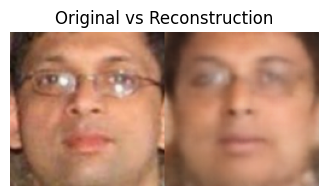

In [3]:
# Prendre une image au hasard
img, true_age_norm = dataset[np.random.randint(len(dataset))]
img = img.unsqueeze(0).to(DEVICE)
true_age = int(true_age_norm.item() * 100)

with torch.no_grad():
    # Forward complet
    recon, mu, _, pred_age_norm, _, _ = model(img)
    
    # Extraction des latents pour usage futur
    z_c = mu[:, :Z_C_DIM]       # L'âge encodé
    z_not_c = mu[:, Z_C_DIM:]   # L'identité encodée

pred_age = int(pred_age_norm.item() * 100)

print(f"Age Réel : {true_age} ans")
print(f"Age Prédit : {pred_age} ans (Erreur: {abs(true_age - pred_age)} ans)")

# Affichage Côte à côte
viz = torch.cat([img, recon], dim=3)
show(viz, title="Original vs Reconstruction")

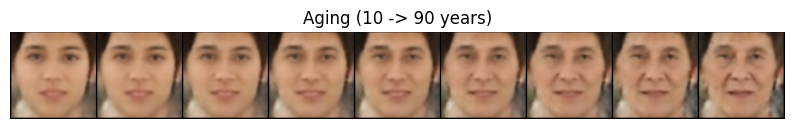

In [27]:
def visualize_aging(model, img_tensor, device='cuda'):
    with torch.no_grad():
        # 1. Extraire le style (Identité)
        _, mu, _, _, _, _ = model(img_tensor)
        z_not_c = mu[:, Z_C_DIM:] # On garde l'identité
        
        # 2. Créer une gamme d'âges cibles (10, 20, ..., 90 ans)
        ages_values = [10, 20, 30, 40, 50, 60, 70, 80, 90]
        target_ages = torch.tensor([a/100.0 for a in ages_values]).view(-1, 1).to(device)
        
        # 3. Calculer les z_c correspondants via le Prior Network
        h_prior = model.prior_net(target_ages)
        z_c_targets = model.prior_mu(h_prior)
        
        # 4. Répéter l'identité pour chaque âge
        z_not_c_repeated = z_not_c.repeat(len(ages_values), 1)
        
        # 5. Fusionner et Décoder
        z_combined = torch.cat([z_c_targets, z_not_c_repeated], dim=1)
        
        # Attention au .view() selon ton architecture (512 ou 256)
        dec_in = model.decoder_input(z_combined).view(-1, 512, 4, 4) 
        generated = model.decoder_conv(dec_in)
        
        # 6. Affichage
        grid = make_grid(generated, nrow=len(ages_values), padding=2)
        show(grid, title="Aging (10 -> 90 years)")

# Test sur une image du loader
batch_imgs, _ = next(iter(dataloader))
visualize_aging(model, batch_imgs[0:1].to(DEVICE), DEVICE)

Age A: 12  | Age B: 34


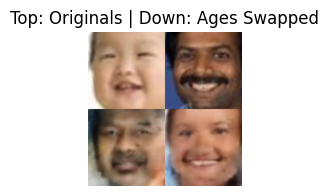

In [17]:
def swap_ages(model, img1, img2):
    with torch.no_grad():
        # Encoder les deux
        _, mu1, _, age1, _, _ = model(img1)
        _, mu2, _, age2, _, _ = model(img2)
        
        # Séparer Age (z_c) et Style (z_not_c)
        z_c_1, z_not_c_1 = mu1[:, :Z_C_DIM], mu1[:, Z_C_DIM:]
        z_c_2, z_not_c_2 = mu2[:, :Z_C_DIM], mu2[:, Z_C_DIM:]
        
        # SWAP : Style 1 + Age 2
        z_swap_1 = torch.cat([z_c_2, z_not_c_1], dim=1)
        
        # SWAP : Style 2 + Age 1
        z_swap_2 = torch.cat([z_c_1, z_not_c_2], dim=1)
        
        # Décodage
        recon1 = model.decoder_conv(model.decoder_input(z_swap_1).view(-1, 512, 4, 4))
        recon2 = model.decoder_conv(model.decoder_input(z_swap_2).view(-1, 512, 4, 4))
        
        # Affichage
        # Ligne 1 : Originaux
        # Ligne 2 : Swapped
        row1 = torch.cat([img1, img2], dim=3)
        row2 = torch.cat([recon1, recon2], dim=3)
        final = torch.cat([row1, row2], dim=2)
        
        print(f"Age A: {int(age1.item()*100)}  | Age B: {int(age2.item()*100)}")
        show(final, title="Top: Originals | Down: Ages Swapped")

# Trouver deux personnes différentes
batch_imgs, _ = next(iter(dataloader))
swap_ages(model, batch_imgs[0:1].to(DEVICE), batch_imgs[1:2].to(DEVICE))